In [11]:
import numpy as np
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm

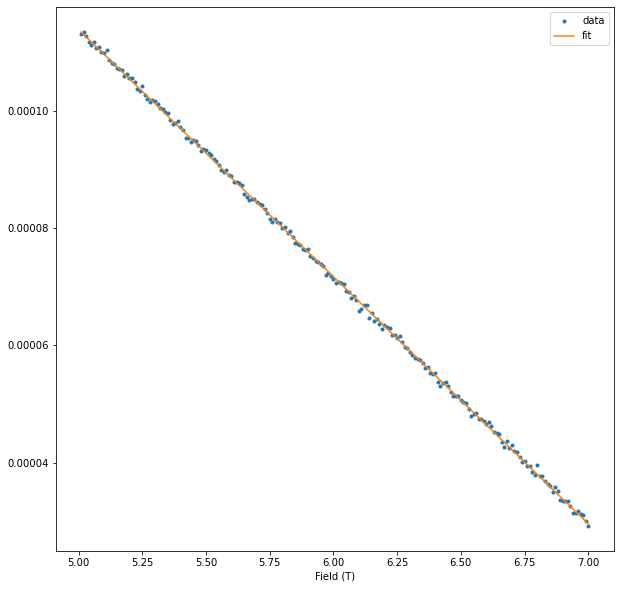

a = -4.210595e-05
b = 3.243267e-04
avg_moment = 3.243267e-04


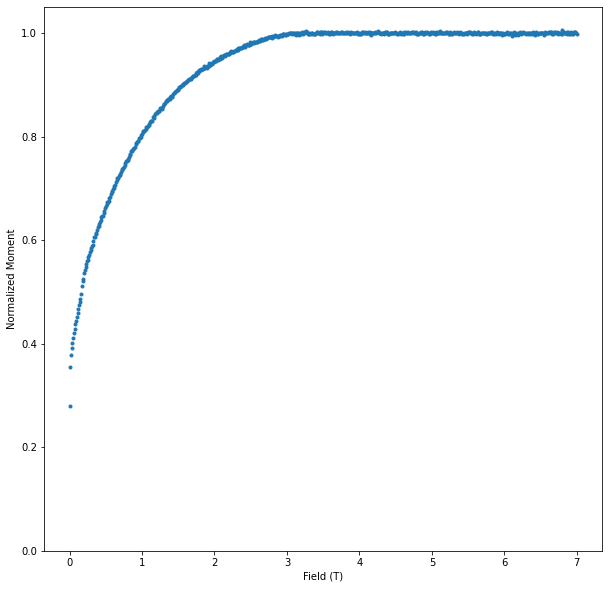

In [2]:
#load data and transpose it into columns
data = np.genfromtxt('/home/jupyter/Girt-lab/J1-7-inplane-295K-N-avg.txt', delimiter = '\t').T
field = data[0]
momentRaw = data[1]


#extract the last N amount of points
length_of_last_points = 200
tail_data = np.array([field[len(field) - length_of_last_points:], momentRaw[len(momentRaw) - length_of_last_points:]])

#fit the tail
a, b = np.polyfit(*tail_data, 1)

#plot the tail and the fit
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(*tail_data, '.', label = 'data')
ax.plot(tail_data[0], a*tail_data[0] + b, label = 'fit')
ax.set(xlabel = 'Field (T)')
ax.legend()
plt.show()


#get some information
moment = momentRaw - field*a
avg_moment = np.mean(moment[len(moment) - length_of_last_points:])
mdata = np.array([field, moment/avg_moment])
norm_moment = moment/avg_moment
print(f"a = {a:.6e}\nb = {b:.6e}\navg_moment = {avg_moment:.6e}")

#plot the normalized moment
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(field, norm_moment, '.')

ax.set(xlabel = 'Field (T)', ylabel = 'Normalized Moment', ylim = (0,1.05))
plt.show()

In [3]:
#constants
d = 2e-8
half_thickness = 4e-7
S = 0.2946635385
M = int(half_thickness/d)
Ms = avg_moment/(2*half_thickness)/S
print(Ms)

1375.8349110381432


In [30]:
A = 3e-6
Msd = Ms*d*10000
Ad = A/d
M = 20
J1 = 2.64
J2 = 1.76

y_int1 = np.cos(np.arccos(-J1/(2*J2))/2)
theta1 = 180 - np.arccos(J1/(2*J2))*180/np.pi

MrMs = mdata[0][1]
theta2 = 180 - np.arccos(np.cos(np.arccos(MrMs)*2)*-1)*180/np.pi


def Energy(thetas,J1, J2, H, Ad, Msd):
    E_RKKY = J1 * np.cos(2*thetas[M-1]) + J2*np.cos(2*thetas[M-1])**2
    E_ex = -4*Ad*(np.sum(np.cos((thetas[:M-1] - thetas[1:M]))))
    E_ZCo = -2*Msd*H*np.sum(np.cos(thetas))
    return E_RKKY + E_ex + E_ZCo



def fit_function(fields, J1, J2, A, ini_thetas = 1*np.ones(M), sort=True):
    mag = np.ones(len(fields))
    upper = 2*np.pi
    for i,field in enumerate(tqdm(fields)):
        Msd = Ms*d*10000
        Ad = A/d
        #minimize the angles
        tmp = []
        
        
        res = minimize(Energy, ini_thetas, args = (J1, J2, field, Ad, Msd), tol = 0.001)
        thetas_opt = res.x
        value = (1/(M)*np.sum(np.cos(thetas_opt)))
        if abs(1-value) > 1e-4:
            mag[i] = value
        else:
            return mag

            
        
    return mag

  0%|          | 0/701 [00:00<?, ?it/s]

CPU times: user 7.44 s, sys: 119 ms, total: 7.56 s
Wall time: 15.9 s


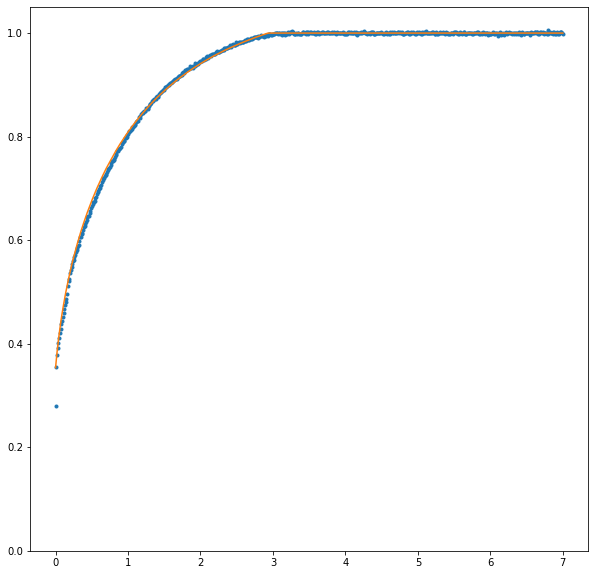

In [31]:
%time mag = fit_function(field,J1,J2,A)

fig = plt.figure(figsize = (10,10))
plt.plot(field, norm_moment,'.')
plt.plot(field, np.array(mag))
plt.ylim(0,1.05)
pOpt = [J1, J2, A]

sigma = 0.01165464674156577
chisq = 0.19223126774611027
sigma = 0.008
chisq = 0.4097367139997721


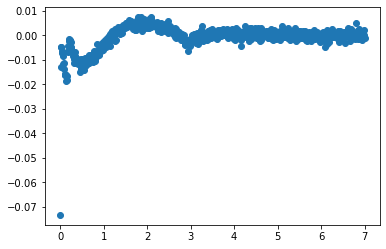

In [32]:
sigma = np.std(mdata[1][length_of_last_points:])
#calculate chisq from the standard deviation of the tail
res = (mdata[1] - mag)
norm_res = res/sigma

plt.plot(mdata[0], res, 'o')
chisq_red = np.sum(norm_res**2)/(len(field))
print(f"sigma = {sigma}\nchisq = {chisq_red}")


#calculate chisq with a sigma of 0.008
norm_res2 = (mdata[1] - mag)/0.008
chisq_red2 = np.sum(norm_res2**2)/(len(field) - 3)
print(f"sigma = {0.008}\nchisq = {chisq_red2}")